# Uncertainty estimation

This notebook performs uncertainty quantification for the U-Net model

In [1]:
from pathlib import Path
import random
from typing import List

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage.io import imread
import svgutils.compose as sc
from IPython.display import SVG
from sklearn.pipeline import make_pipeline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from carde.io import image_path, tiled_image_path, tiled_label_path
from carde.io import read_image_pair
from carde.image_processing import RobustImageScaler, CompleteImageTiler
from carde.dataset import SEMTileDataset, split_data
from carde.unet import SegmentationModel_mve, NLLWarmupCallback
from carde.evalmetrics import (
    classical_segmentation,
    plot_loss,
    plot_reliability_diagram,
    evaluate_model,
    probs_to_confidence_map,
    mve_confidence_map,
    plot_confidence_map,
    predict_logits_mean_sigma,
    logits_mean_sigma_to_probabilities,
    baseline_and_model_scores,
)

## Figure parameters

In [2]:
devices=(4,) # which GPU devices to use, e.g. (0,1) for multi-GPU training
_ = torch.manual_seed(42)
np.random.seed(5)
random.seed(13)
device_name = f"cuda:{devices[0]}" if torch.cuda.is_available() else "cpu"

# figure parameters
plt.rcParams['svg.fonttype'] = 'none'  # editable text in svg vector formats
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']

# figure sizes
textwidth = 7.05  # inches
onecolumn = 3.42  # inches
# set the default figure size to one column width
plt.rcParams["figure.figsize"] = (textwidth, onecolumn)

figure_path = Path('../paper/figures')
figure_path.mkdir(parents=True, exist_ok=True)

## Image metadata for scale bars

In [3]:
pixel_size = 8  # nanometers per pixel
scale_bar_length = 300  # nanometers
scale_bar_length_px = scale_bar_length / pixel_size  # in pixels

## Data and model architecture

In [4]:
raw_image_path = image_path.parent.parent / "01-02"
se2_image = imread(raw_image_path / "Original SEM Images" / "WD_06mm_001.tif")
in_lens_image = imread(raw_image_path / "Original SEM Images" / "WD_06mm_002.tif")
label_image = imread(raw_image_path / "05a_Particle_Image_Filtered.bmp")

## Model training

In [5]:
model_path = tiled_label_path.parent.parent / "tb_logs"
model_name = "unet_model_mve"

In [6]:
# create dataset
dataset = SEMTileDataset(tiled_image_path, tiled_label_path, train=True)
# create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# split data into three sets: train, validation, and test
train_loader, val_loader, test_loader = split_data(dataset, batch_size=32, train_ratio=0.8, val_ratio=0.1)

In [7]:
print(f"Batches in training data loader: {len(train_loader)}")
print(f"Batches in validation data loader: {len(val_loader)}")
print(f"Batches in test data loader: {len(test_loader)}")

print(f"Number of samples in training data loader: {len(train_loader.dataset)}")
print(f"Number of samples in validation data loader: {len(val_loader.dataset)}")
print(f"Number of samples in test data loader: {len(test_loader.dataset)}")

total_samples = len(train_loader.dataset) + len(val_loader.dataset) + len(test_loader.dataset)
print(f"Total number of samples: {total_samples}")


Batches in training data loader: 48
Batches in validation data loader: 6
Batches in test data loader: 6
Number of samples in training data loader: 1536
Number of samples in validation data loader: 192
Number of samples in test data loader: 192
Total number of samples: 1920


In [8]:
# load existing model if available

model_path.mkdir(parents=True, exist_ok=True)
checkpoint_paths = list((model_path / model_name).glob("**/*.ckpt"))
if checkpoint_paths:
    print(f"Found existing checkpoints: {list(checkpoint_paths)}. Using the latest one for training.")
    checkpoint_path = max(checkpoint_paths, key=lambda p: p.stat().st_mtime)
    print(f"Loading checkpoint from {checkpoint_path}")
else:
    checkpoint_path = None
    print("No checkpoints found. Starting training from scratch.")

Found existing checkpoints: [PosixPath('../../data/cloud/tb_logs/unet_model_mve/version_0/checkpoints/epoch=101-step=4896.ckpt')]. Using the latest one for training.
Loading checkpoint from ../../data/cloud/tb_logs/unet_model_mve/version_0/checkpoints/epoch=101-step=4896.ckpt


In [9]:
# TensorBoard Logger
logger = TensorBoardLogger(str(model_path), name=model_name)
logger

In [10]:
# training the model
early_stop_callback = EarlyStopping(
    monitor="validation_loss", mode="min", patience=14, verbose=True
)

warmup_callback = NLLWarmupCallback(warmup_epochs=10)

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    devices=devices,
    enable_progress_bar=True,
    callbacks=[early_stop_callback, warmup_callback],
    logger=logger,
)

if checkpoint_path is not None:
    # Load model from checkpoint
    model = SegmentationModel_mve.load_from_checkpoint(
        str(checkpoint_path),
        in_channels=2,
        out_channels=2,
        blocks=3,
        hidden_layers_block1=128,
        lr=0.0002,
        lr_scheduler_patience=7,
        regression=False,
    )
    print(f"Model loaded from checkpoint: {checkpoint_path}")
    # If you want to continue training from the checkpoint, run the next line
    # trainer.fit(model, train_loader, val_loader, ckpt_path=str(checkpoint_path))
else:
    # Create new model and train from scratch
    model = SegmentationModel_mve(
        in_channels=2,
        out_channels=2,
        blocks=3,
        hidden_layers_block1=128,
        lr=0.0002,
        lr_scheduler_patience=7,
    )
    trainer.fit(model, train_loader, val_loader)

/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model loaded from checkpoint: ../../data/cloud/tb_logs/unet_model_mve/version_0/checkpoints/epoch=101-step=4896.ckpt


In [11]:
avg_loss, avg_score = evaluate_model(model, val_loader, trainer, show_sample=False, n_samples=3)

/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_flo

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.047970134764909744
       test_score           0.9520298838615417
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Average Dice Loss: 0.0480
Average 1 - Dice Loss: 0.9520


In [12]:
log_dir = model_path / model_name / "version_0"
event_acc = EventAccumulator(str(log_dir))

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['validation_loss', 'validation_score', 'epoch', 'train_loss_epoch', 'train_dice_loss_epoch', 'train_nll_epoch', 'var_loss_weight_epoch', 'train_loss_step', 'train_dice_loss_step', 'train_nll_step', 'var_loss_weight_step', 'test_loss', 'test_score'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


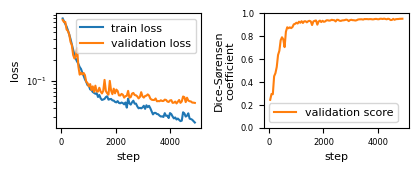

In [ ]:
# event_acc = EventAccumulator(trainer.logger.log_dir)
event_acc.Reload()
print(event_acc.Tags())

layout = [["Loss", "Score"]]
fig, ax = plt.subplot_mosaic(layout, figsize=(textwidth * 0.6, textwidth/4))
axs = list(ax.values())
plot_loss(event_acc, axs=axs[:2], yscale="log")
fig.tight_layout()


## Figure 3: model evaluation

In [14]:
baseline_scores, unet_scores = baseline_and_model_scores(
    test_data_loader=test_loader,
    model=model,
)

In [15]:
# create dataframe for seaborn
df = pd.DataFrame({
    'score': baseline_scores + unet_scores,
    'method': ['Baseline'] * len(baseline_scores) + ['U-Net'] * len(unet_scores)
})

In [16]:
# Check statistical significance using a Wilcoxon signed-rank test
from scipy.stats import wilcoxon
C, p = wilcoxon(baseline_scores, unet_scores)
print(f"Median (IQR) baseline score: {np.median(baseline_scores):.2f} ({np.percentile(baseline_scores, 25):.3f} - {np.percentile(baseline_scores, 75):.3f})")
print(f"Median (IQR) U-Net score: {np.median(unet_scores):.2f} ({np.percentile(unet_scores, 25):.3f} - {np.percentile(unet_scores, 75):.3f})")
print(f"Wilcoxon signed-rank test: C={C}, p-value={p}")

Median (IQR) baseline score: 0.85 (0.522 - 0.919)
Median (IQR) U-Net score: 0.98 (0.962 - 0.991)
Wilcoxon signed-rank test: C=9.0, p-value=4.947850801101778e-33


In [17]:
# SE2, InLens, Label, Prediction
def plot_predictions(
    model: SegmentationModel_mve, test_data_loader: DataLoader, trainer: pl.Trainer, n_samples=3, axs=None, fig=None
):
    optimal_T = torch.Tensor([1.87117]).to(device_name)  # determined from the validation set in the notebook Uncertainty_quantification.ipynb
    inputs, labels = next(iter(test_data_loader))

    idxs = random.sample(range(inputs.size(0)), n_samples)
    if axs is None:
        fig, ax = plt.subplots(n_samples, 5, figsize=(textwidth, 4 * n_samples))
        axs = ax.ravel()
    else:
        assert len(axs) == n_samples * 5, f"axs must have n_samples * 5 = {n_samples * 5} axes, got {len(axs)}"
    for i, idx in enumerate(idxs):
        baseline = classical_segmentation(inputs[idx])
        axs_index = i * 5
        axs[axs_index + 0].imshow(inputs[idx, 0].cpu(), cmap="gray")
        axs[axs_index + 1].imshow(inputs[idx, 1].cpu(), cmap="gray")
        plot_confidence_map((labels[idx, 0].cpu() > 0) * 3, ax=axs[axs_index + 2], fig=fig, color_bar=False)
        axs[axs_index + 2].set_title("")
        plot_confidence_map(baseline * 3, ax=axs[axs_index + 3], fig=fig, color_bar=False)
        axs[axs_index + 3].set_title("")
        single_image_loader = DataLoader(Subset(test_data_loader.dataset, [idx]), batch_size=1)
        logits, sigma = predict_logits_mean_sigma(model, single_image_loader)
        probs = logits_mean_sigma_to_probabilities(logits, sigma)
        confidence_map = probs_to_confidence_map(probs).squeeze().cpu()
        if i == 0:
            plot_confidence_map(confidence_map, ax=axs[axs_index + 4], fig=fig)
            scalebar = AnchoredSizeBar(
                axs[3].transData,
                scale_bar_length_px,
                f"{scale_bar_length} nm",
                "upper right",
                pad=0.1,
                color="white",
                frameon=False,
                size_vertical=1,
                fontproperties={"size": 6},
            )
            axs[axs_index + 0].add_artist(scalebar)
            axs[axs_index + 0].set_title("SE2")
            axs[axs_index + 1].set_title("InLens")
            axs[axs_index + 2].set_title("Label")
            axs[axs_index + 3].set_title("Baseline")
            axs[axs_index + 4].set_title("Predicted")
        else:
            plot_confidence_map(confidence_map, ax=axs[axs_index + 4], fig=fig, color_bar=False)
            axs[axs_index + 4].set_title("")

    for ax in axs:
        ax.axis("off")
    return axs

/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |          | 0/? [00:00<?, ?it/s]

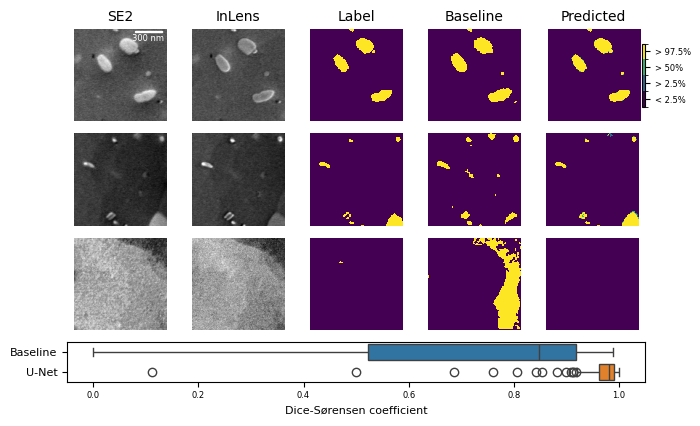

In [ ]:
# create figure
n_samples = 3
layout = []
for n in range(n_samples):
    layout.append([f"SE2_{n}", f"InLens_{n}", f"Label_{n}", f"Baseline_{n}", f"Predicted_{n}"])
    layout.append([f"SE2_{n}", f"InLens_{n}", f"Label_{n}", f"Baseline_{n}", f"Predicted_{n}"])

layout.append(["Scores", "Scores", "Scores", "Scores", "Scores"])

fig, ax = plt.subplot_mosaic(layout, figsize=(textwidth, textwidth * 0.61 ))
axs = list(ax.values())

sns.boxplot(data=df, x="score", y="method", hue="method", orient="h", ax=ax["Scores"])
ax["Scores"].set_xlabel("Dice-Sørensen coefficient")
ax["Scores"].set_ylabel("")
# increase ytick font size
ax["Scores"].tick_params(axis='y', labelsize=8)
plot_predictions(model=model, test_data_loader=test_loader, trainer=trainer, n_samples=n_samples, axs=axs[:n_samples * 5], fig=fig)
fig.tight_layout()

## Figure 4: Transfer to unseen image from different experiment

In [ ]:
def plot_whole_image_comparison(
    model: SegmentationModel_mve,
    trainer: pl.Trainer,
    image_file: Path,
    label_file: Path,
    tile_size: int = 128,
    stride: int = 128,
    device="cpu",
):
    # load full image

    se2, inlens = read_image_pair(image_file)
    full_image = np.asarray([se2, inlens])

    # load label
    full_label = imread(label_file)

    # baseline
    baseline_full = classical_segmentation(
        torch.tensor(full_image, dtype=torch.float32)
    )

    # tiling inputs & labels
    tiler = make_pipeline(
        RobustImageScaler(),
        CompleteImageTiler(tile_size=tile_size, stride=stride),
    )
    tiles = tiler.fit_transform(full_image)

    tiles_tensor = torch.tensor(tiles, dtype=torch.float32)

    # dataset (inputs, labels) -> we can just use inputs twice here, because labels are not used for prediction
    tile_ds = torch.utils.data.TensorDataset(tiles_tensor, tiles_tensor)
    tile_dl = torch.utils.data.DataLoader(tile_ds, batch_size=32, shuffle=False)

    # prediction
    pred_tiles = mve_confidence_map(model, tile_dl)

    # merge predictions back to full image
    merger = CompleteImageTiler(tile_size=tile_size, stride=stride)
    merger.fit(full_label)
    full_pred_mask = merger.inverse_transform(pred_tiles.cpu().numpy())

    # calculate scores
    full_label_tensor = (
        torch.tensor((full_label > 0), dtype=torch.float32)
        .to(device_name)
        .unsqueeze(0)
        .unsqueeze(0)
    )
    baseline_full_tensor = (
        torch.tensor(baseline_full, dtype=torch.float32)
        .to(device_name)
        .unsqueeze(0)
        .unsqueeze(0)
    )
    full_pred_mask_tensor = torch.tensor(full_pred_mask, device=device_name).unsqueeze(0).unsqueeze(0)
    baseline_score = 1 - model.dice_loss(baseline_full_tensor, full_label_tensor)
    unet_score = 1 - model.dice_loss(full_pred_mask_tensor > 0.5, full_label_tensor)
    print(f"Baseline score on full image: {baseline_score.item():.3f}")
    print(f"U-Net score on full image: {unet_score.item():.3f}")

    fig, axs = plt.subplots(2, 2, figsize=(textwidth, 0.67 * textwidth))

    ax = axs.ravel()

    combined_input = np.stack([se2, inlens], axis=0)
    ax[0].imshow(np.max(combined_input, axis=0), cmap="gray")
    ax[0].set_title("Input (SE2+InLens)")
    full_image_scalebar_length = 2000  # nanometers
    full_image_scalebar_length_px = full_image_scalebar_length / pixel_size  # in pixels
    scalebar = AnchoredSizeBar(
        ax[0].transData,
        full_image_scalebar_length_px,
        f"{full_image_scalebar_length // 1000} µm",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 6},
    )
    ax[0].add_artist(scalebar)

    plot_confidence_map((full_label > 0) * 3, ax=ax[1], fig=fig, color_bar=False)
    ax[1].set_title("Label")

    plot_confidence_map((baseline_full > 0) * 3, ax=ax[2], fig=fig, color_bar=False)
    ax[2].set_title("Baseline")

    plot_confidence_map(full_pred_mask.squeeze(), ax=ax[3], fig=fig, color_bar=True)
    ax[3].set_title("U-Net Prediction")

    for a in ax:
        a.axis("off")

    plt.tight_layout()
    plt.show()

/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_1193933/3943930027.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(baseline_full, dtype=torch.float32)


Baseline score on full image: 0.880
U-Net score on full image: 0.952


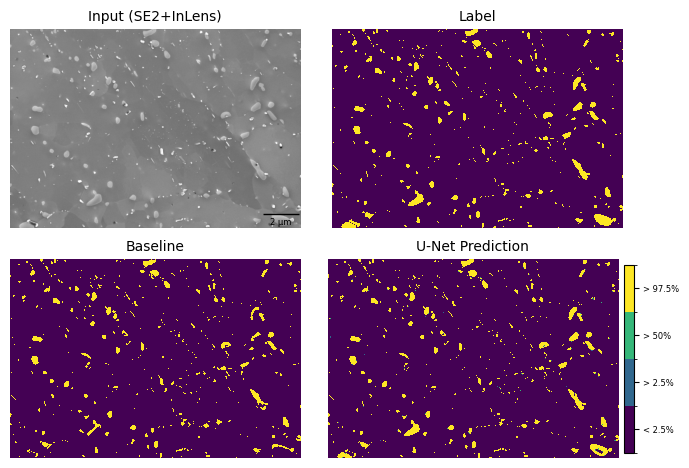

In [20]:
image_file = image_path.parent / "hold-out" / "WD6mm_31.tif"
label_file = image_path.parent / "hold-out" / "WD6mm_31_label.png"
plot_whole_image_comparison(model, trainer, image_file, label_file)

## Plot reliability diagram

In [21]:
logits, sigma = predict_logits_mean_sigma(model, val_loader)
probs = logits_mean_sigma_to_probabilities(logits, sigma)
labels_list = []
for _, labels in val_loader:
    labels_list.append(labels)
labels = torch.cat(labels_list, dim=0)


/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'reliability diagram'}, xlabel='confidence', ylabel='accuracy'>

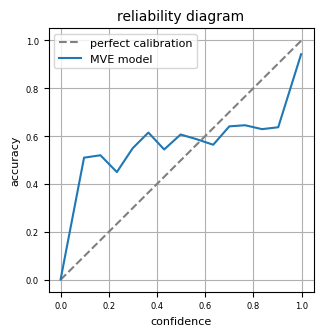

In [22]:
plot_reliability_diagram([probs], labels, legend_labels=["MVE model"])


## Plot uncertainty

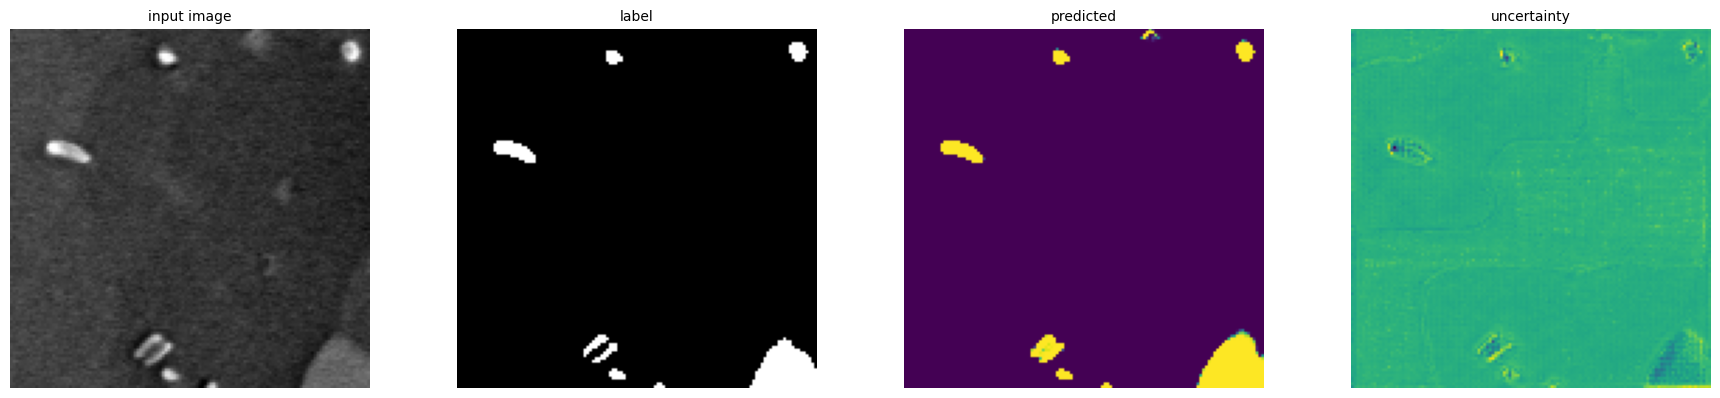

In [23]:
def plot_prediction_uncertainty(model, dataset, device="cpu", index=0):
    model.eval()
    model = model.to(device)

    images, labels = dataset[index]
    images = images.to(device)

    with torch.no_grad():
        pred_logits, sigma = model.forward_mean_var(images.unsqueeze(0))
    probs = logits_mean_sigma_to_probabilities(pred_logits, sigma).cpu().squeeze().numpy()
    uncertainty = sigma.cpu().squeeze().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs[0].imshow(images[1].cpu(), cmap="gray")
    axs[0].set_title("input image")
    axs[0].axis("off")

    axs[1].imshow(labels[0].cpu(), cmap="gray")
    axs[1].set_title("label")
    axs[1].axis("off")

    axs[2].imshow(probs, cmap="viridis")
    axs[2].set_title("predicted")
    axs[2].axis("off")

    axs[3].imshow(uncertainty, cmap="viridis")
    axs[3].set_title("uncertainty")
    axs[3].axis("off")

    fig.tight_layout()
    plt.show()

plot_prediction_uncertainty(model, test_loader.dataset, device=device_name, index=18)